### Debugger

33
(33, 190)
We are good to go!!
(48, 193)
27
===== START SIMULATION =====


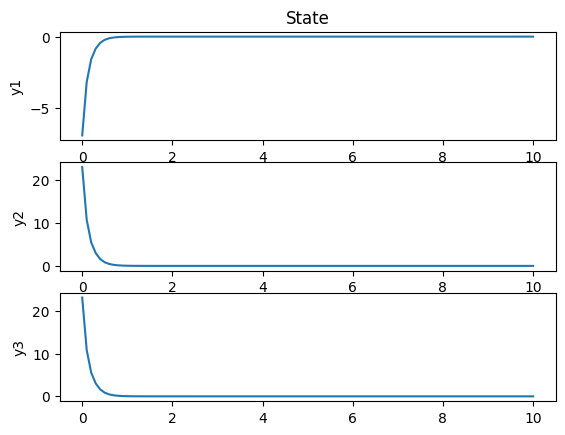

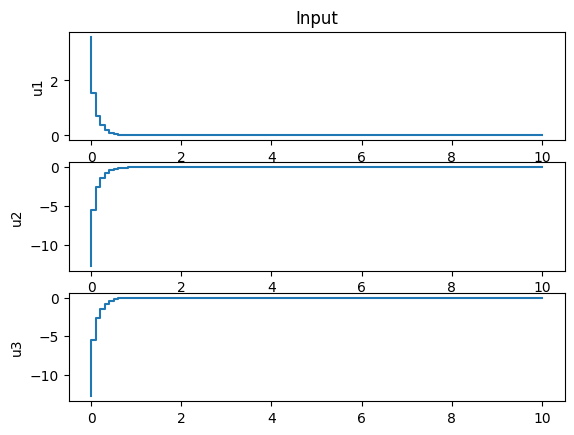

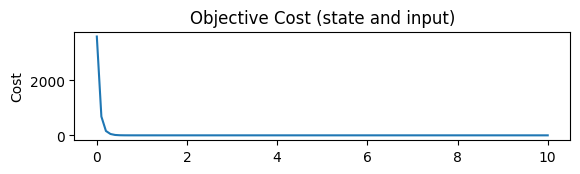

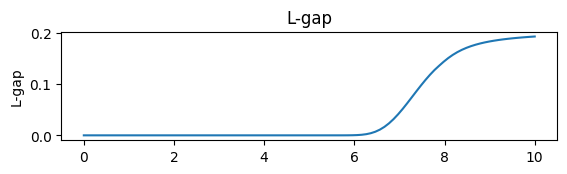

In [40]:
from math import ceil
import numpy as np 
import cvxpy as cp 
import random
import matplotlib.pyplot as plt
from deepc import DeePC
from numpy import linalg
import pandas as pd

# Define system
A = np.array([[1.01,0.01,0],[0.01,1.01,0.01],[0,0.01,1.01]])
B = np.eye(3)
C = np.eye(3)
(n,m) = B.shape                                 # n = number of states, m = number of inputs
p = n                                           # p = number of output
        
# Simulation    
x0 = np.array([[0],[0],[1]])
t_step = 0.1
t_sim = 20.0 #4.3#20.0                          # simulation time 
n_sim = ceil(t_sim/t_step)                      # Number of simulation step n_sim >= (m+1)*(T_ini + N + n(B)) - 1
x = x0 
xData = np.empty((n,n_sim+1))
yData = np.empty((n,n_sim+1))
xData[:,[0]] = x0
yData[:,[0]] = x0
uData = np.empty((m,n_sim))

# Generate random input sequence
np.random.seed(1)
u_seq = np.array(np.random.rand(m,n_sim))
# measurement noise
mu = 0 #0.5
sigma = 0.0 # 0.2

# -- Collect data
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData[:,[t]] = u 
    xData[:,[t+1]] = x
    yData[:,[t+1]] = y

# -- set parameters
params = {}
params['uData'] = uData
params['yData'] = yData[:,1:] #xData[:,1:]
params['N'] = 5
params['Q'] = np.eye(3)
params['R'] = np.eye(3)*10
params['lambda_slack'] = 10**3# 10**7
params['lambda_g'] = 100#300# 100
params['ulim'] = 5

# -- create controller    
controller = DeePC(params,constr_u = False)
# controller.create_Hankel_check()

# -- offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  

# -- Simulation setup for initial state  
x0 = np.array([[-20],[5],[1]])
t_step = 0.1
t_sim = 3.0                                    # simulation time 
n_sim = ceil(t_sim/t_step)                     # Number of simulation step > Tini + N + iter - 1
x = x0 
xData_ini = np.empty((n,n_sim+1))
xData_ini[:,[0]] = x0; 
uData_ini = np.empty((m,n_sim))
yData_ini = np.empty((p,n_sim+1))
yData_ini[:,[0]] = x0
Tini = n

# ======== GROUSE ========
low_dimension_rank = 3*(3+5)+3                 # m*(Tini+Tf)+n
controller.create_U1(low_dimension_rank)
GROUSE_ENABLE = True
step_size = 0.01
grouse_iter = 20
u_obs = np.zeros((m*(Tini + params['N'] + grouse_iter - 1),1))
y_obs = np.zeros((p*(Tini + params['N'] + grouse_iter - 1),1))

# -- Generate random input sequence
np.random.seed(5)
u_seq = np.array(np.random.rand(m,n_sim))

# -- Generate initial state
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData_ini[:,[t]] = u 
    xData_ini[:,[t+1]] = x
    yData_ini[:,[t+1]] = y
        
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y    
    
# Simulation    
print("===== START SIMULATION =====")
x0 = xData_ini[:,-1]
y0 = yData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 10.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))
yLog = np.zeros((n,n_sim+1))
yLog[:,0] = y0

# ======== GROUSE DATA LOG ========
U_true = controller.create_U1(low_dimension_rank)
subspaceLog = np.empty((1,n_sim))
if GROUSE_ENABLE:
    U_predictor = controller.create_U1(low_dimension_rank)
else:
    U_predictor = controller.Hankel_PF
CHANGE_ENABLE = True
t_change = 5
A_0 = A[0,0]

# -- Run simulation
for t in range(n_sim):  
    if CHANGE_ENABLE:   
        if t>= t_change/t_step:
            A[0,0] = A_0 + 0.2*np.log(t)
        
    # u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
    u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)

    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    y = C@x+w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    y_vec = np.reshape(y,(-1, 1))
    cost = y_vec.T @ params['Q'] @ y_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    yLog[:,[t+1]] = y_vec
    costLog[0,[t]] = cost
    # subspaceLog[0,[t]] = np.linalg.norm(U_true@np.transpose(U_true)-U_predictor@np.transpose(U_predictor),'fro')
    subspaceLog[0,[t]] = 27 - (np.linalg.norm(U_true.T@U_predictor,'fro'))**2
    
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y_vec]])
    
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u_vec    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y_vec    
    
    if GROUSE_ENABLE:
        for i in range(grouse_iter):
            # step_size_dim = np.exp(-i)*step_size
            step_size_dim = step_size
            u_temp = u_obs[m*(grouse_iter-i-1):u_obs.shape[0]-m*i,:]
            y_temp = y_obs[p*(grouse_iter-i-1):y_obs.shape[0]-p*i,:]
            u_p = u_temp[:m*Tini,:]
            u_f = u_temp[m*Tini:,:]
            y_p = y_temp[:p*Tini,:]
            y_f = y_temp[p*Tini:,:]    
            v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])      
            v_unit = v_obs/np.linalg.norm(v_obs,2) 
            U_predictor = controller.grouse_update(U_predictor,v_unit,step_size_dim)          
    else:
        pass

# Plot system evolution    
y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.plot(time,xLog[0,:])
plt.ylabel('y1')
plt.title('State')

plt.subplot(312)
plt.plot(time,xLog[1,:])   
plt.ylabel('y2')

plt.subplot(313)
plt.plot(time,xLog[2,:])
plt.ylabel('y3')


# Plot input evolution    
u_plot = plt.figure(2)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.step(time,uLog[0,:])
plt.ylabel('u1')
plt.title('Input')

plt.subplot(312)
plt.step(time,uLog[1,:])   
plt.ylabel('u2')

plt.subplot(313)
plt.step(time,uLog[2,:])
plt.ylabel('u3')

# Plot cost  
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,costLog[0,:])
plt.ylabel('Cost')
plt.title('Objective Cost (state and input)')

# Plot subspace tracking  
sst_plot = plt.figure(4)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,subspaceLog[0,:])
plt.ylabel('L-gap')
plt.title('L-gap')

plt.show()


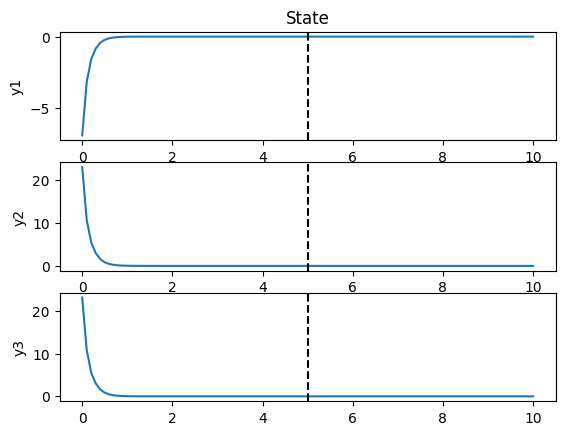

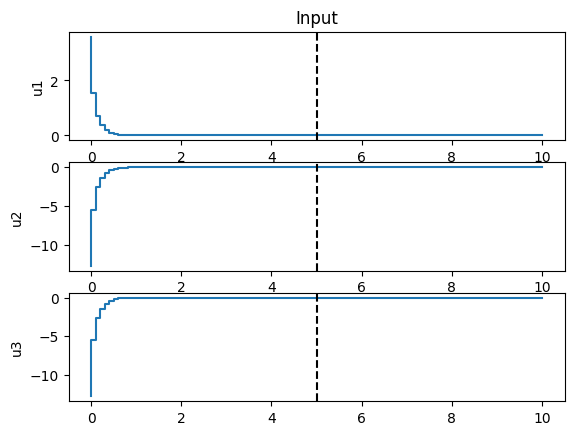

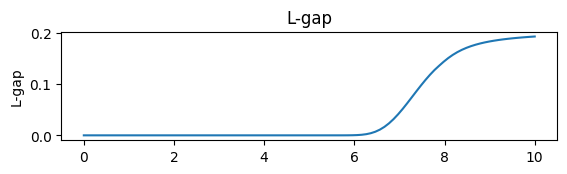

In [38]:
# Plot system evolution    
y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.plot(time,xLog[0,:])
plt.axvline(x=t_change, color='k', ls='--')
plt.ylabel('y1')
plt.title('State')

plt.subplot(312)
plt.plot(time,xLog[1,:])   
plt.axvline(x=t_change, color='k', ls='--')
plt.ylabel('y2')

plt.subplot(313)
plt.plot(time,xLog[2,:])
plt.axvline(x=t_change, color='k', ls='--')
plt.ylabel('y3')


# Plot input evolution    
u_plot = plt.figure(2)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.step(time,uLog[0,:])
plt.axvline(x=t_change, color='k', ls='--')
plt.ylabel('u1')
plt.title('Input')

plt.subplot(312)
plt.step(time,uLog[1,:])  
plt.axvline(x=t_change, color='k', ls='--') 
plt.ylabel('u2')

plt.subplot(313)
plt.step(time,uLog[2,:])
plt.axvline(x=t_change, color='k', ls='--')
plt.ylabel('u3')

# Plot subspace tracking  
sst_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,subspaceLog[0,:])
plt.ylabel('L-gap')
plt.title('L-gap')

plt.show()

### Debugger 2

In [2]:
from math import ceil
import numpy as np 
import cvxpy as cp 
import random
import matplotlib.pyplot as plt
from deepc import DeePC
from numpy import linalg
import pandas as pd

# Define system
A = np.array([[0]])
B = np.array([[1]])
C = np.array([[1]])
(n,m) = B.shape                                 # n = number of states, m = number of inputs
p = n                                           # p = number of output
        
# Simulation    
x0 = np.array([[0]])
t_step = 0.1
t_sim = 20.0 #4.3#20.0                          # simulation time 
n_sim = ceil(t_sim/t_step)                      # Number of simulation step n_sim >= (m+1)*(T_ini + N + n(B)) - 1
x = x0 
xData = np.empty((n,n_sim+1))
yData = np.empty((n,n_sim+1))
xData[:,[0]] = x0
yData[:,[0]] = x0
uData = np.empty((m,n_sim))

# Generate random input sequence
np.random.seed(1)
u_seq = np.array(np.random.rand(m,n_sim))
# measurement noise
mu = 0 #0.5
sigma = 0.0 # 0.2

# Collect data
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData[:,[t]] = u 
    xData[:,[t+1]] = x
    yData[:,[t+1]] = y

# set parameters
params = {}
params['uData'] = uData
params['yData'] = yData[:,1:] #xData[:,1:]
params['N'] = 1
params['Q'] = 1
params['R'] = 10
params['lambda_slack'] = 10**3# 10**7
params['lambda_g'] = 100#300# 100
params['ulim'] = 5

# create controller    
controller = DeePC(params,constr_u = False)
# controller.create_Hankel_check()

# offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  

# Simulation setup for initial state  
x0 = np.array([0])
t_step = 0.1
t_sim = 3.0                                    # simulation time 
n_sim = ceil(t_sim/t_step)                     # Number of simulation step > Tini + N + iter - 1
x = x0 
xData_ini = np.empty((n,n_sim+1))
xData_ini[:,[0]] = x0; 
uData_ini = np.empty((m,n_sim))
yData_ini = np.empty((p,n_sim+1))
yData_ini[:,[0]] = x0
Tini = n

# ======== GROUSE ========
low_dimension_rank = 3
controller.create_U1(low_dimension_rank)
GROUSE_ENABLE = True
step_size = 0.01
grouse_iter = 1
u_obs = np.zeros((m*(Tini + params['N'] + grouse_iter - 1),1))
y_obs = np.zeros((p*(Tini + params['N'] + grouse_iter - 1),1))

# Generate random input sequence
np.random.seed(5)
u_seq = np.array(np.random.rand(m,n_sim))

# Generate initial state
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData_ini[:,[t]] = u 
    xData_ini[:,[t+1]] = x
    yData_ini[:,[t+1]] = y
        
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y    
    
# Simulation    
print("===== START SIMULATION =====")
x0 = xData_ini[:,-1]
y0 = yData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 10.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))
yLog = np.zeros((n,n_sim+1))
yLog[:,0] = y0

# ======== GROUSE DATA LOG ========
U_true = controller.create_U1(low_dimension_rank)
subspaceLog = np.empty((1,n_sim))
if GROUSE_ENABLE:
    U_predictor = controller.create_U1(low_dimension_rank)
    print("debug norm")
    print(np.linalg.norm(U_true@np.transpose(U_true)-U_predictor@np.transpose(U_predictor),2))
else:
    U_predictor = controller.Hankel_PF


A_0 = A[0,0]
# run simulation
for t in range(n_sim):     
    # if t>= 50:
    #     if t == 50:
    #         print("HERE")
    #     A[0,0] = A_0 + 0.2*np.log(t)
        
    # u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
    u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)

    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    y = C@x+w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    y_vec = np.reshape(y,(-1, 1))
    cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    yLog[:,[t+1]] = y_vec
    costLog[0,[t]] = cost
    # subspaceLog[0,[t]] = np.linalg.norm(U_true@np.transpose(U_true)-U_predictor@np.transpose(U_predictor),'fro')
    subspaceLog[0,[t]] = 27 - (np.linalg.norm(U_true.T@U_predictor,'fro'))**2
    
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y_vec]])
    
    # update u_obs, y_obs
    u_obs = np.roll(u_obs,-Tini)
    u_obs[-Tini:,:] = u_vec    
    y_obs = np.roll(y_obs,-Tini)
    y_obs[-Tini:,:] = y_vec    
    
    # u_p = u_obs[:m*Tini,:]
    # u_f = u_obs[m*Tini:,:]
    # y_p = y_obs[:p*Tini,:]
    # y_f = y_obs[p*Tini:,:]    
    # v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])
   
    if GROUSE_ENABLE:
        for i in range(grouse_iter):
            # step_size_dim = np.exp(-i)*step_size
            step_size_dim = step_size
            u_temp = u_obs[m*(grouse_iter-i-1):u_obs.shape[0]-m*i,:]
            y_temp = y_obs[p*(grouse_iter-i-1):y_obs.shape[0]-p*i,:]
            u_p = u_temp[:m*Tini,:]
            u_f = u_temp[m*Tini:,:]
            y_p = y_temp[:p*Tini,:]
            y_f = y_temp[p*Tini:,:]    
            v_obs = np.block([[u_p],[y_p],[u_f],[y_f]])       
            U_predictor = controller.grouse_update(U_predictor,v_obs,step_size_dim)          
    else:
        pass

# Plot system evolution    
y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.plot(time,xLog[0,:])
plt.ylabel('y1')
plt.title('State')

plt.subplot(312)
plt.plot(time,xLog[1,:])   
plt.ylabel('y2')

plt.subplot(313)
plt.plot(time,xLog[2,:])
plt.ylabel('y3')


# Plot input evolution    
u_plot = plt.figure(2)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.step(time,uLog[0,:])
plt.ylabel('u1')
plt.title('Input')

plt.subplot(312)
plt.step(time,uLog[1,:])   
plt.ylabel('u2')

plt.subplot(313)
plt.step(time,uLog[2,:])
plt.ylabel('u3')

# Plot subspace tracking  
sst_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,subspaceLog[0,:])
plt.ylabel('L-gap')
plt.title('L-gap')


plt.show()


3
(3, 198)
We are good to go!!
(4, 199)
2
===== START SIMULATION =====
debug norm
0.0
1
10
var11[0, 0]
(1,)


AttributeError: 'index' object has no attribute 'reshape'

### Debugger 3

In [2]:
U_predictor.shape

(48, 27)

In [3]:
u = controller.computeInputGROUSE(u_ini,y_ini,U_predictor).reshape(m, 1)

In [10]:
U_predictor.shape

(48, 27)

In [19]:
np.linalg.svd(v_obs.T@U_true)[1]

array([1.04967578e-09])

In [21]:
v_unit = v_obs/np.linalg.norm(v_obs,2)

In [22]:
np.linalg.svd(v_unit.T@U_true)[1]

array([1.])

In [24]:
np.linalg.svd(U_true.T@U_predictor)[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
np.linalg.svd(U_true.T@U_predictor)[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

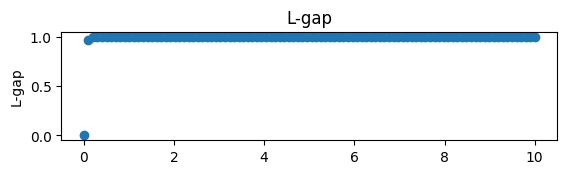

In [12]:
# Plot subspace tracking  
%matplotlib inline
sst_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.plot(time,subspaceLog[0,:],'o')
plt.ylabel('L-gap')
plt.title('L-gap')


plt.show()



In [19]:
np.linalg.pinv(U_predictor).shape

(27, 48)

In [16]:
i = 2
u_temp = u_obs[m*(grouse_iter-i-1):u_obs.shape[0]-m*i,:]
print(u_temp.shape)

(24, 1)


Text(0.5, 1.0, 'L-gap')

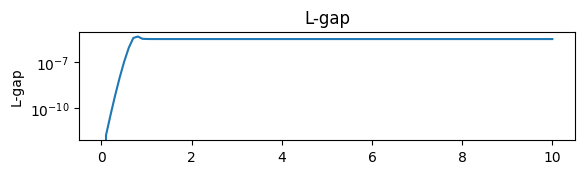

In [53]:
# Plot subspace tracking  
sst_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.semilogy(time,subspaceLog[0,:])
plt.ylabel('L-gap')
plt.title('L-gap')

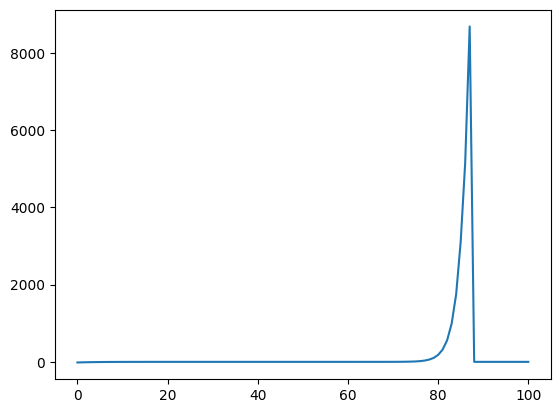

In [46]:
plt.plot(xLog[0,:])
plt.show()

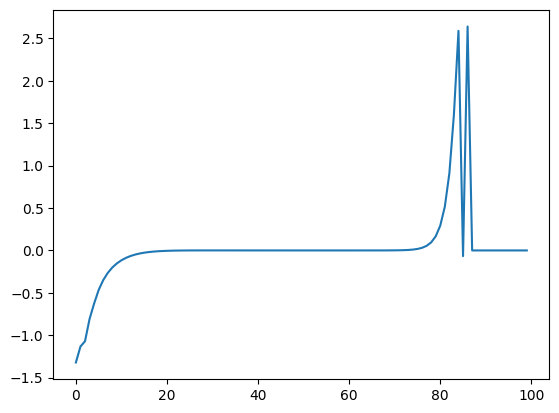

In [49]:
plt.plot(uLog[2,:])
plt.show()

In [6]:
%matplotlib qt
plt.plot(s, 'bo')
plt.show()

In [32]:
0.2*np.log(100)

0.9210340371976184

## MAIN

### Import requirement library

In [3]:
from math import ceil
import numpy as np 
import cvxpy as cp 
import random
import matplotlib.pyplot as plt
from deepc import DeePC
from numpy import linalg
import pandas as pd


### Collect Data

In [8]:
# Define system
A = np.array([[1.01,0.01,0],[0.01,1.01,0.01],[0,0.01,1.01]])
B = np.eye(3)
C = np.eye(3)
(n,m) = B.shape                                 # n = number of states, m = number of inputs
p = n                                           # p = number of output
        
# Simulation    
x0 = np.array([[0],[0],[1]])
t_step = 0.1
t_sim = 4.3#20.0                                    # simulation time 
n_sim = ceil(t_sim/t_step)                     # Number of simulation step n_sim >= (m+1)*(T_ini + N + n(B)) - 1
x = x0 
xData = np.empty((n,n_sim+1))
yData = np.empty((n,n_sim+1))
xData[:,[0]] = x0
yData[:,[0]] = x0
uData = np.empty((m,n_sim))

# Generate random input sequence
np.random.seed(1)
u_seq = np.array(np.random.rand(m,n_sim))
# measurement noise
mu = 0 #0.5
sigma = 0.2 # 0.2

# Collect data
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData[:,[t]] = u 
    xData[:,[t+1]] = x
    yData[:,[t+1]] = y

### Create DeePC controller

In [10]:
# set parameters
params = {}
params['uData'] = uData
params['yData'] = yData[:,1:] #xData[:,1:]
params['N'] = 5
params['Q'] = np.eye(3)
params['R'] = np.eye(3)*10
params['lambda_slack'] = 10**3#10**3# 10**7
params['lambda_g'] = 100#300# 100

# create controller    
controller = DeePC(params)
# controller.create_Hankel_check()

# offline computation
controller.create_Hankel_check()      
controller.create_Hankel()  

33
(33, 33)
We are good to go!!
(48, 36)
36


### Generate Initial State

In [13]:
# Simulation    
x0 = np.array([[-20],[5],[1]])
t_step = 0.1
t_sim = 1.0;                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0; 
xData_ini = np.empty((n,n_sim+1))
xData_ini[:,[0]] = x0; 
uData_ini = np.empty((m,n_sim))
yData_ini = np.empty((n,n_sim+1))
yData_ini[:,[0]] = x0; 
    
# Generate random input sequence
np.random.seed(5)
u_seq = np.array(np.random.rand(m,n_sim))

# Collect data
for t in range(n_sim):
    u = u_seq[:, t].reshape(m, 1)
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = A@x+B@u
    y = C@x+w
    uData_ini[:,[t]] = u 
    xData_ini[:,[t+1]] = x
    yData_ini[:,[t+1]] = y

### Simulation

In [14]:
# Simulation    
x0 = xData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 10.0;                                  # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))
yLog = np.zeros((n,n_sim+1))
yLog[:,0] = x0
    
# run simulation
for t in range(n_sim):
    u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
    # u = np.zeros((m,1))
    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    y = C@x+w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    y_vec = np.reshape(y,(-1, 1))
    cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    yLog[:,[t+1]] = y_vec
    costLog[0,[t]] = cost
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y_vec]])

#### Plot Result

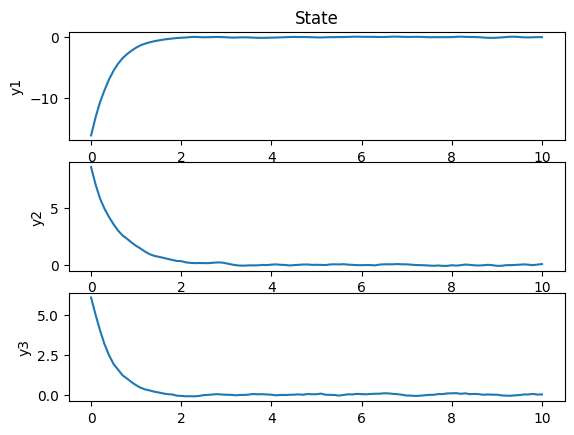

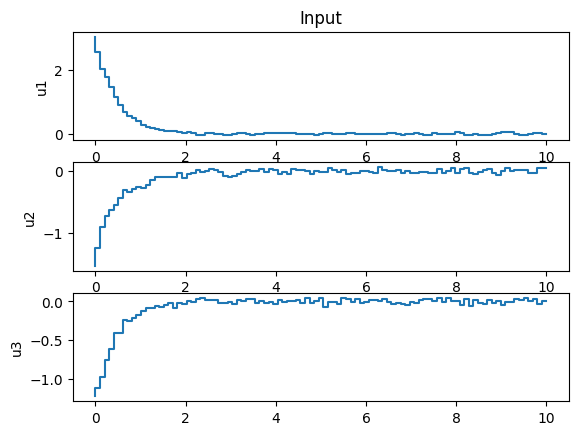

In [15]:
# Plot system evolution    
y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

plt.subplot(311)
plt.plot(time,xLog[0,:])
plt.ylabel('y1')
plt.title('State')

plt.subplot(312)
plt.plot(time,xLog[1,:])   
plt.ylabel('y2')

plt.subplot(313)
plt.plot(time,xLog[2,:])
plt.ylabel('y3')


# Plot input evolution    
u_plot = plt.figure(2)
time = np.linspace(0,t_sim,n_sim);
plt.subplot(311)
plt.step(time,uLog[0,:])
plt.ylabel('u1')
plt.title('Input')

plt.subplot(312)
plt.step(time,uLog[1,:])   
plt.ylabel('u2')

plt.subplot(313)
plt.step(time,uLog[2,:])
plt.ylabel('u3')

plt.show()

#### Check

In [14]:
# Simulation    
x0 = xData_ini[:,-1]
u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
y_ini = np.reshape(xData_ini[:,-n:],(-1, 1), order='F') 
t_step = 0.1
t_sim = 0.5                                    # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
x = x0.reshape(m, 1)
xLog = np.zeros((n,n_sim+1))
xLog[:,0] = x0
uLog = np.empty((m,n_sim))
costLog = np.empty((1,n_sim))

(gg, uPred, yPred) = controller.computeDeePC(u_ini,y_ini)
   
# run simulation
for t in range(n_sim):
    u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
    x = A@x+B@u    
    w = np.random.normal(mu, sigma, size=(n, 1))
    x = x + w
    u_vec = np.reshape(u,(-1, 1))
    x_vec = np.reshape(x,(-1, 1))
    cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
    uLog[:,[t]] = u_vec
    xLog[:,[t+1]] = x_vec
    costLog[0,[t]] = cost
    y = x_vec
    u_ini = np.block([[u_ini[n:]],[u_vec]])
    y_ini = np.block([[y_ini[n:]],[y]])

[[-4.95817086e-06]
 [ 1.83290625e-04]
 [ 1.19936995e-01]
 [-1.18486637e-05]
 [ 5.24420626e+00]
 [ 1.22351814e-01]
 [ 5.76216052e+00]
 [ 6.05669483e-01]
 [ 2.16780619e+00]
 [ 1.97812735e+00]
 [ 2.73682499e+00]
 [ 1.03604828e-05]
 [ 1.69718762e-05]
 [ 5.34515951e-05]
 [-3.67363101e-05]
 [-1.63857722e-05]
 [-7.71764245e-01]
 [-5.70869409e-05]
 [ 5.78743213e-05]
 [-5.22112155e-05]
 [-1.71439882e+00]
 [-3.85670543e+00]
 [-7.51676203e+00]
 [ 5.78392388e-05]
 [-1.07699678e+00]
 [-1.82783219e-01]
 [-3.62516785e-05]
 [-8.93662015e-02]
 [-1.26435078e-04]
 [-6.83326959e-04]
 [-4.75430194e-05]
 [ 3.25122043e-01]
 [ 3.98061358e+00]
 [ 5.63213691e-05]
 [ 6.26324584e-05]
 [ 1.04005488e+00]]
[[-4.95817086e-06]
 [ 1.83290625e-04]
 [ 1.19936995e-01]
 [-1.18486637e-05]
 [ 5.24420626e+00]
 [ 1.22351814e-01]
 [ 5.76216052e+00]
 [ 6.05669483e-01]
 [ 2.16780619e+00]
 [ 1.97812735e+00]
 [ 2.73682499e+00]
 [ 1.03604828e-05]
 [ 1.69718762e-05]
 [ 5.34515951e-05]
 [-3.67363101e-05]
 [-1.63857722e-05]
 [-7.717642

In [17]:
x = x0.reshape(m, 1)
xLogggg = np.zeros((3,params['N']))
for i in range(params['N']):
    u = uPred[n*i:n*i+n]
    x = A@x+B@u
    xLogggg[:,[i]] = x
    print(x)
print(xLogggg)

[[-15.71954944]
 [  5.17695355]
 [ 10.83256137]]
[[-11.54633885]
 [  6.71315409]
 [ 13.43313238]]
[[-0.18976949]
 [ 7.04782545]
 [12.55374407]]
[[ 5.52288659]
 [ 8.91835094]
 [20.2441634 ]]
[[12.97055457]
 [18.20935882]
 [24.73012598]]
[[-15.71954944 -11.54633885  -0.18976949   5.52288659  12.97055457]
 [  5.17695355   6.71315409   7.04782545   8.91835094  18.20935882]
 [ 10.83256137  13.43313238  12.55374407  20.2441634   24.73012598]]


In [16]:
print(uPred.reshape(3,-1, order='F'))
print(yPred.reshape(3,-1, order='F'))

[[-0.50338453  4.27863654 11.40490121  5.64407553  7.3032556 ]
 [-3.73800913  1.53330089  0.24867188  1.67640749  8.94415387]
 [ 4.33675413  2.44047587 -1.08085117  7.49440363  4.19433744]]
[[-15.9988941  -13.07348961  -0.31262303   5.35411903  11.32058717]
 [  7.6333002    6.17324855   8.14414871   6.41003787  18.63732617]
 [  8.37721289  11.849823     7.45684853  21.34213023  19.5328847 ]]


In [23]:
print(xLogggg - yPred.reshape(3,-1, order='F'))


[[ 0.27934467  1.52715075  0.12285354  0.16876756  1.6499674 ]
 [-2.45634665  0.53990555 -1.09632326  2.50831308 -0.42796735]
 [ 2.45534848  1.58330939  5.09689554 -1.09796683  5.19724128]]


#### Plot cost

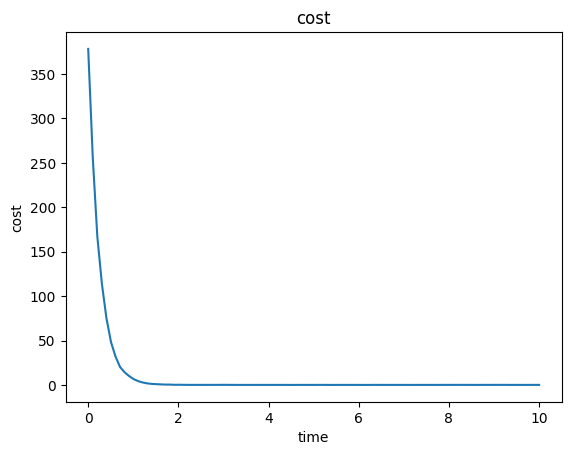

In [16]:
# Plot cost evolution    
cost_plot = plt.figure(3)
time = np.linspace(0,t_sim,n_sim)
plt.plot(time,costLog[0,:])
plt.ylabel('cost')
plt.xlabel('time')
plt.title('cost')

plt.show()

### Regularization

#### Iterate for lambda y

(48, 193)
48


c:\Users\Jzeta\anaconda3\envs\ifaenv\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0
91551.81861257963
(48, 193)
48
1
89827.16434524771
(48, 193)
48
2
74648.46474723148
(48, 193)
48
3
18515.198388626588
(48, 193)
48
4
2057.914031504889
(48, 193)
48
5
1201.6248161876251
(48, 193)
48
6
1142.0085946600318
(48, 193)
48
7
1139.6814023294787
(48, 193)
48
8
1135.818180089006
(48, 193)
48
9
1133.155337264076
(48, 193)
48
10
1134.1067027295285
(48, 193)
48
11
1136.241159208295


<Figure size 640x480 with 0 Axes>

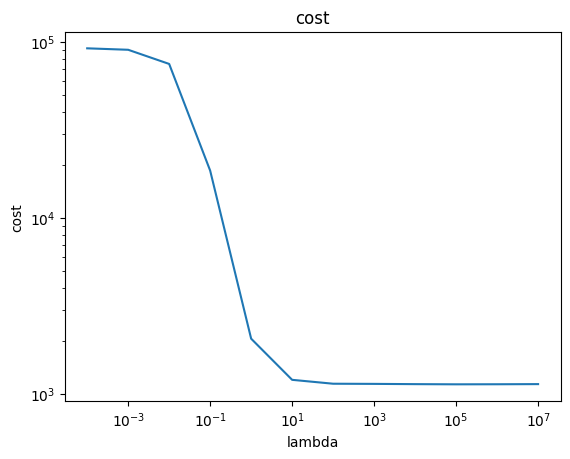

In [11]:

# Simulation   
# lambda_List = np.linspace(1,1000,30)
# lambda_List = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000] 
lambda_List = np.geomspace(10**-4, 10**7, num=12)
t_step = 0.1
t_sim = 20.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_g'] = 100

# run simulation
for i in range(len(lambda_List)):
    params['lambda_slack'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()     
    # init new log
    x0 = xData_ini[:,-1]
    y0 = yData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
    t_step = 0.1
    t_sim = 10.0;                                  # simulation time
    n_sim = ceil(t_sim/t_step)                     # Number of simulation step
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))
    yLog = np.zeros((n,n_sim+1))
    yLog[:,0] = y0

    for t in range(n_sim):
        u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
        # u = np.zeros((m,1))
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        y = C@x+w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        y_vec = np.reshape(y,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        yLog[:,[t+1]] = y_vec
        costLog[0,[t]] = cost
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y_vec]])
    print(i)
    print(np.sum(costLog))
    
    sumcostLog[0,[i]] = np.sum(costLog)

y_plot = plt.figure(1)
time = np.linspace(0,t_sim,n_sim+1)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()


#### Iterate for lambda g

(48, 193)
48
(48, 193)
48
(48, 193)
48
(48, 193)
48
(48, 193)
48
(48, 193)
48
(48, 193)
48
(48, 193)
48


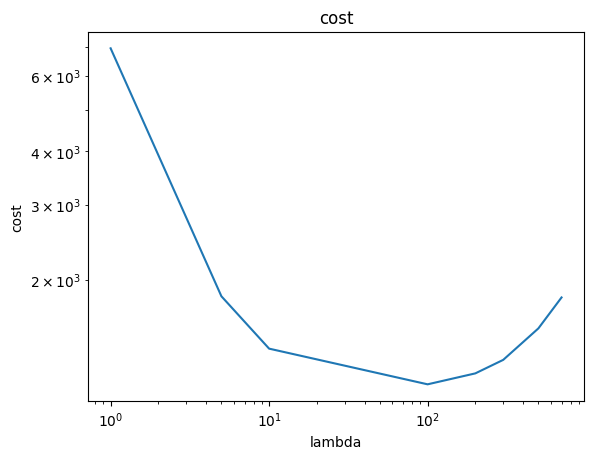

In [12]:
# Simulation   
# lambda_List = [10**-4,10**-3,10**-2,10**-1,10**-0,10**1,10**2,10**3,10**4] 
# lambda_List = np.linspace(1,1000,30)
lambda_List = [1,5,10,100,200,300,500,700]
t_step = 0.1
t_sim = 1.0                                   # simulation time
n_sim = ceil(t_sim/t_step)                     # Number of simulation step
sumcostLog = np.empty((1,len(lambda_List)))
params['lambda_slack'] = 10**3

# run simulation
for i in range(len(lambda_List)):
    params['lambda_g'] = lambda_List[i]
    # create controller    
    controller = DeePC(params) 
    controller.create_Hankel()     
    # init new log
    x0 = xData_ini[:,-1]
    y0 = yData_ini[:,-1]
    u_ini = np.reshape(uData_ini[:,-n:],(-1, 1), order='F') 
    y_ini = np.reshape(yData_ini[:,-n:],(-1, 1), order='F') 
    t_step = 0.1
    t_sim = 10.0;                                  # simulation time
    n_sim = ceil(t_sim/t_step)                     # Number of simulation step
    x = x0.reshape(m, 1)
    xLog = np.zeros((n,n_sim+1))
    xLog[:,0] = x0
    uLog = np.empty((m,n_sim))
    costLog = np.empty((1,n_sim))
    yLog = np.zeros((n,n_sim+1))
    yLog[:,0] = y0

    for t in range(n_sim):
        u = controller.computeInput(u_ini,y_ini).reshape(m, 1)
        # u = np.zeros((m,1))
        x = A@x+B@u    
        w = np.random.normal(mu, sigma, size=(n, 1))
        y = C@x+w
        u_vec = np.reshape(u,(-1, 1))
        x_vec = np.reshape(x,(-1, 1))
        y_vec = np.reshape(y,(-1, 1))
        cost = x_vec.T @ params['Q'] @ x_vec + u_vec.T @ params['R'] @ u_vec
        uLog[:,[t]] = u_vec
        xLog[:,[t+1]] = x_vec
        yLog[:,[t+1]] = y_vec
        costLog[0,[t]] = cost
        u_ini = np.block([[u_ini[n:]],[u_vec]])
        y_ini = np.block([[y_ini[n:]],[y_vec]])
    # print(np.sum(costLog))
    sumcostLog[0,[i]] = np.sum(costLog)

# Plot cost evolution    
cost_plot = plt.figure(4)
plt.loglog(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()


In [17]:
plt.plot(lambda_List,sumcostLog.reshape(-1,1))
plt.ylabel('cost')
plt.xlabel('lambda')
plt.title('cost')
plt.show()

NameError: name 'lambda_List' is not defined

In [22]:
print(sumcostLog)

[[1141.27479752]]
